In [2]:
import camb
import numpy as np
import matplotlib.pyplot as plt

In [14]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12,8)

In [19]:
#Gotta have that fall matplotlib aesthetic
c1 = 'xkcd:wine'
c2 = 'xkcd:mustard yellow'
c3 = 'xkcd:copper'

### a)

In [15]:
arr = np.genfromtxt('wmap_tt_spectrum_9yr_v5.txt')
l = arr[:,0]
C_l = arr[:,1]
err = arr[:,2]

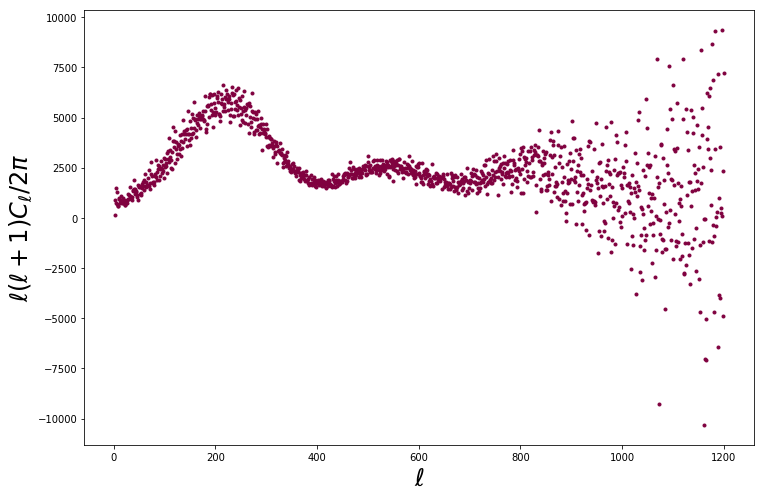

In [20]:
plt.plot(l,C_l,marker='.',ls='',c=c1)
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$',fontsize=24)
plt.show()

In [21]:
cosmology = np.array([0.02256,0.1142,2.40e-9,0.9710,0.0851,69.7])

In [30]:
pars = camb.CAMBparams()
pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
pars.set_for_lmax(int(l.max()))
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [42]:
C_l_gen = powers['total'][int(l.min()):int(l.max()+1),0]

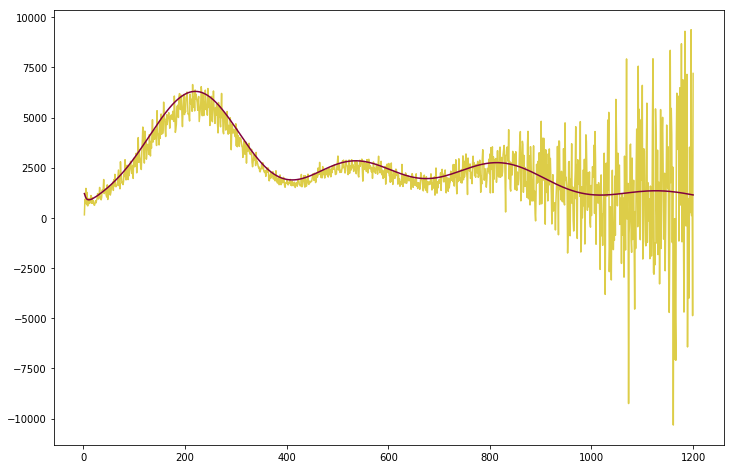

In [68]:
plt.plot(l,C_l,c=c2,alpha=0.75)
plt.plot(l,C_l_gen,c=c1)

## b)

In [50]:
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

In [53]:
def get_step(step_size=[1,1,1,1,1,1]):
    step_size = np.array(step_size)
    step = np.random.randn(len(step_size))*step_size
    return step

In [55]:
def get_spectrum(cosmology):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
    pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
    pars.set_for_lmax(int(l.max()))
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    C_l_gen_new = powers['total'][int(l.min()):int(l.max()+1),0]
    return C_l_gen_new

In [108]:
def run_mcmc(data,err,init_cosmology,init_chisq,step_size,nstep):
    n_accepted = 0
    chain = np.zeros((nstep,len(init_cosmology)+2))
    
    for i in range(nstep):
        chain[i,0] = i+1
        print('On step %.0f' % (i+1))
        step = get_step(step_size=step_size)
        new_cosmology = init_cosmology + step
        C_l_gen_new = get_spectrum(new_cosmology)
        new_chisq = get_chisq(data,C_l_gen_new,err)
        delchisq = new_chisq - init_chisq
        prob = np.exp(-0.5*delchisq)
        accept = np.random.rand() < prob
        if accept:
            print('Step accepted!')
            print('Delta chisq: %.2f' % (delchisq))
            print('Probability: %.2f \n' % (prob))
            n_accepted += 1
            init_cosmology = new_cosmology
            init_chisq = new_chisq
        chain[i,1] = init_chisq
        chain[i,2:len(init_cosmology)+2] = init_cosmology
        
    print('Percentage of steps accepted: %.2f' % (n_accepted/nstep))
    return chain

I'll try and figure out a good stepsize for my first parameter. Let's estimate five percent of the initial parameter is a reasonable step size, and see how many steps are accepted:

In [112]:
chisq = get_chisq(C_l,C_l_gen,err)
step_size = [0.05*cosmology[0],0,0,0,0,0]
nstep = 100
chain_ombh2 = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep)

On step 1
On step 2
On step 3
Step accepted!
Delta chisq: 0.60
Probability: 0.74 

On step 4
On step 5
On step 6
Step accepted!
Delta chisq: -0.06
Probability: 1.03 

On step 7
Step accepted!
Delta chisq: -4.80
Probability: 11.03 

On step 8
On step 9
Step accepted!
Delta chisq: 1.13
Probability: 0.57 

On step 10
On step 11
On step 12
On step 13
Step accepted!
Delta chisq: -0.49
Probability: 1.28 

On step 14
On step 15
On step 16
On step 17
On step 18
On step 19
Step accepted!
Delta chisq: -0.21
Probability: 1.11 

On step 20
On step 21
On step 22
Step accepted!
Delta chisq: -0.45
Probability: 1.25 

On step 23
Step accepted!
Delta chisq: -0.03
Probability: 1.01 

On step 24
Step accepted!
Delta chisq: 0.84
Probability: 0.66 

On step 25
On step 26
Step accepted!
Delta chisq: -1.26
Probability: 1.88 

On step 27
On step 28
On step 29
On step 30
On step 31
On step 32
On step 33
On step 34
On step 35
On step 36
On step 37
On step 38
On step 39
Step accepted!
Delta chisq: 0.25
Probabili

In [113]:
ombh2 = chain_ombh2[:,2]
chisq_ombh2 = chain_ombh2[:,1]

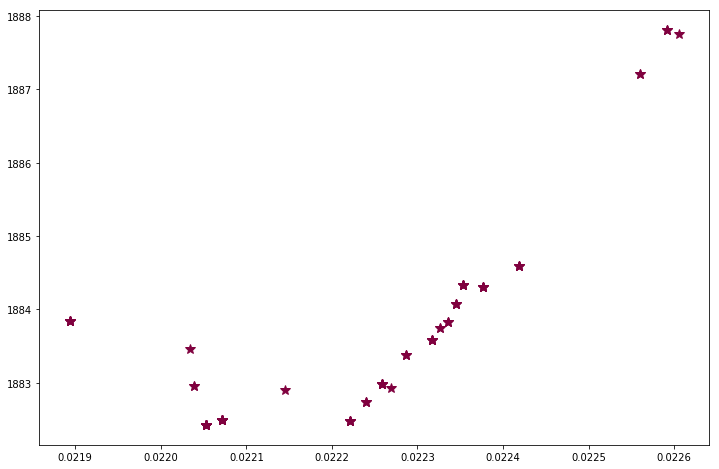

In [114]:
plt.plot(ombh2,chisq_ombh2,marker='*',ls='',c=c1,markersize=10)

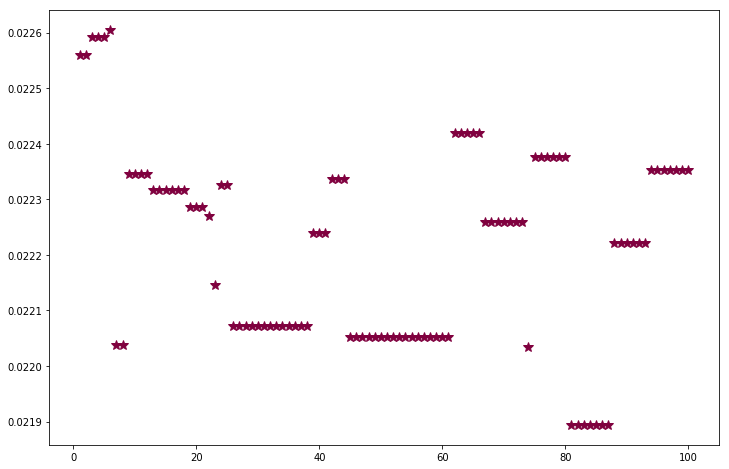

In [115]:
plt.plot(chain_ombh2[:,0],ombh2,marker='*',ls='',c=c1,markersize=10)